# Preprocess

(704, 13)
(704,)
(161, 13)
(161,)

(704, 13)
(704,)
(161, 13)
(161,)


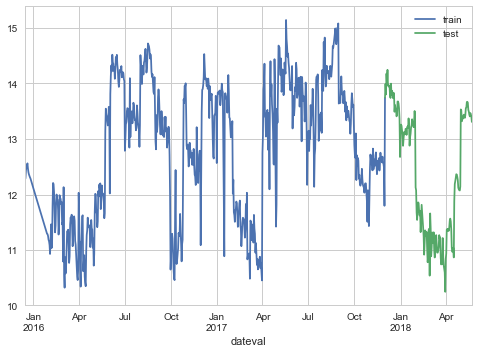

In [70]:
import keras
import pandas as pd
import pandasql as ps
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from pandas import DataFrame
from sklearn.model_selection import TimeSeriesSplit
from typing import Set, Any
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)
np.seterr(divide='ignore', invalid='ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential # Tells you which is the backend used (i.e. Tensorflow)
from keras.layers import Dense  # The same Keras code is used for each backend.
from keras.optimizers import Adam, SGD

df = pd.read_csv("data/data.csv")
df = ps.sqldf("""select * from df order by dateval asc""")
df = df[["dateval", "log_y"]]
df["dateval"] = pd.to_datetime(df["dateval"])
df = df.set_index("dateval")

df['log_y_tomorrow'] = df['log_y'].shift(-1)
df = df.dropna()

df = df.iloc[0:890]
split_date = pd.Timestamp("2017-12-01")

train = df.loc[:split_date, ['log_y']]
test = df.loc[split_date:, ['log_y']]

ax = train['log_y'].plot()
test['log_y'].plot(ax=ax)
plt.legend(['train', 'test'])

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

for column in train.columns:
    train[[column]] = sc.fit_transform(train[[column]])
    test[[column]] = sc.transform(test[[column]])

train['tomorrow_log_y'] = train['log_y'].shift(-1)    
test['tomorrow_log_y'] = test['log_y'].shift(-1)    

for s in range(1, 13):
    train['log_y_lag_{}'.format(s)] = train['log_y'].shift(s)
    test['log_y_lag_{}'.format(s)] = test['log_y'].shift(s)

train = train.dropna()
test = test.dropna()

X_train = train.drop("tomorrow_log_y", axis=1).values
y_train = train['tomorrow_log_y'].values

X_test = test.drop("tomorrow_log_y", axis=1).values
y_test = test['tomorrow_log_y'].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print()

features = X_train.shape[1]

# reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Train

In [71]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import Dropout

from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import BatchNormalization

K.clear_session()
model = Sequential()
model.add(Dense(36, input_dim=X_train.shape[1:], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(18, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(9, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(2, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1)) # 1 output

model.compile(loss='mean_squared_error', optimizer='sgd', lr= 0.005)
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test),
          batch_size=2, verbose=0)
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

TypeError: Error converting shape to a TensorShape: int() argument must be a string, a bytes-like object or a number, not 'tuple'.

# Evaluate

Average amount off = 0.2612970535302551
Model off = 65.37%

Baseline average prediction off = 55.79%
Better than baseline average prediction = -17.17%

Baseline yesterday prediction off = 13.82%
Better than baseline yesterday prediction = -373.02%


/Users/peterjmyers/Work/keras_timeseries/venv/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2250: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


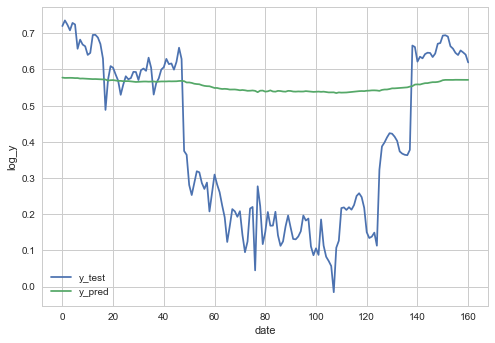

In [65]:
y_pred = model.predict(X_test)
from sklearn.metrics import mean_squared_error
from math import sqrt
y_test_mean = y_test.mean()

baseline_average = np.zeros(len(y_test))
baseline_average.fill(y_test_mean)

baseline_yesterday = np.concatenate(([y_train[-1]], y_test[:-1]))

rmse = sqrt(mean_squared_error(y_test, y_pred))
model_pct_off = rmse / y_test_mean

baseline_average_pct_off = sqrt(mean_squared_error(y_test, baseline_average)) / y_test_mean
pct_improvement_over_baseline_average = (model_pct_off/baseline_average_pct_off - 1)*-1

baseline_yesterday_pct_off = sqrt(mean_squared_error(y_test, baseline_yesterday)) / y_test_mean
pct_improvement_over_baseline_yesterday = (model_pct_off/baseline_yesterday_pct_off - 1)*-1

print("Average amount off = {}".format(rmse))
print("Model off = {:.2%}".format(model_pct_off))
print()
print("Baseline average prediction off = {:.2%}".format(baseline_average_pct_off))
print("Better than baseline average prediction = {:.2%}".format(pct_improvement_over_baseline_average))
print()
print("Baseline yesterday prediction off = {:.2%}".format(baseline_yesterday_pct_off))
print("Better than baseline yesterday prediction = {:.2%}".format(pct_improvement_over_baseline_yesterday))
plt.plot(y_test)
plt.plot(y_pred)
plt.ylabel('log_y')
plt.xlabel('date')
plt.legend(['y_test', 'y_pred'], loc='lower left')
plt.show()